In [29]:
import os
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121, ResNet50 ,VGG16
from tensorflow.keras.models import Model
import shutil

In [7]:
class Data:
    def _subset_directory(self, input_dir, max_images_per_class=50):
        subset_dir = input_dir + '_subset'
        if os.path.exists(subset_dir):
            shutil.rmtree(subset_dir)
        os.makedirs(subset_dir, exist_ok=True)
        for class_name in os.listdir(input_dir):
            class_path = os.path.join(input_dir, class_name)
            subset_class_path = os.path.join(subset_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            os.makedirs(subset_class_path, exist_ok=True)
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            subset_files = image_files[:max_images_per_class]
            for img_file in subset_files:
                src_path = os.path.join(class_path, img_file)
                dst_path = os.path.join(subset_class_path, img_file)
                shutil.copy(src_path, dst_path)
        return subset_dir


In [8]:
obj=Data()
train_dir = obj._subset_directory('140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train',max_images_per_class=10000)
val_dir = obj._subset_directory('140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid',max_images_per_class=5000)
test_dir = obj._subset_directory('140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test',max_images_per_class=7000)

In [30]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(val_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [31]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)
target_size = (256,256)
batch_size = 32  # Update this according to your batch size

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)


test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 20000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
Found 14000 images belonging to 2 classes.


In [32]:
# Verify class distribution
print("Training class distribution:", train_generator.class_indices)
print("Validation class distribution:", val_generator.class_indices)

Training class distribution: {'fake': 0, 'real': 1}
Validation class distribution: {'fake': 0, 'real': 1}


In [33]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [34]:
# Add custom layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-3:]:  # Unfreeze the last 4 layers (customize this as needed)
    layer.trainable = True

# Recompile the model after making layers trainable
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # You can reduce the learning rate further if needed
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [35]:
# Define callbacks
callbacks = [
    ModelCheckpoint('images_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

In [36]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=4,
    callbacks=callbacks
)

Epoch 1/4
625/625 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.7451
Epoch 1: val_accuracy improved from -inf to 0.84260, saving model to images_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 302s 473ms/step - loss: 0.4951 - accuracy: 0.7451 - val_loss: 0.3504 - val_accuracy: 0.8426 - lr: 1.0000e-05
Epoch 2/4
625/625 [==============================] - ETA: 0s - loss: 0.2496 - accuracy: 0.8971
Epoch 2: val_accuracy improved from 0.84260 to 0.93130, saving model to images_model.h5
625/625 [==============================] - 297s 476ms/step - loss: 0.2496 - accuracy: 0.8971 - val_loss: 0.1717 - val_accuracy: 0.9313 - lr: 1.0000e-05
Epoch 3/4
625/625 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.9487
Epoch 3: val_accuracy improved from 0.93130 to 0.95160, saving model to images_model.h5
625/625 [==============================] - 295s 471ms/step - loss: 0.1337 - accuracy: 0.9487 - val_loss: 0.1247 - val_accuracy: 0.9516 - lr: 1.0000e-05
Epoch 4/4
625/625 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.9682
Epoch 4: val_accuracy improved from 0.95160 to 0.96450, saving model to images_mode

In [37]:
test_metrics = model.evaluate(test_generator)
print("Test metrics:", test_metrics[1])

438/438 [==============================] - 154s 352ms/step - loss: 0.0982 - accuracy: 0.9599
Test metrics: 0.959857165813446


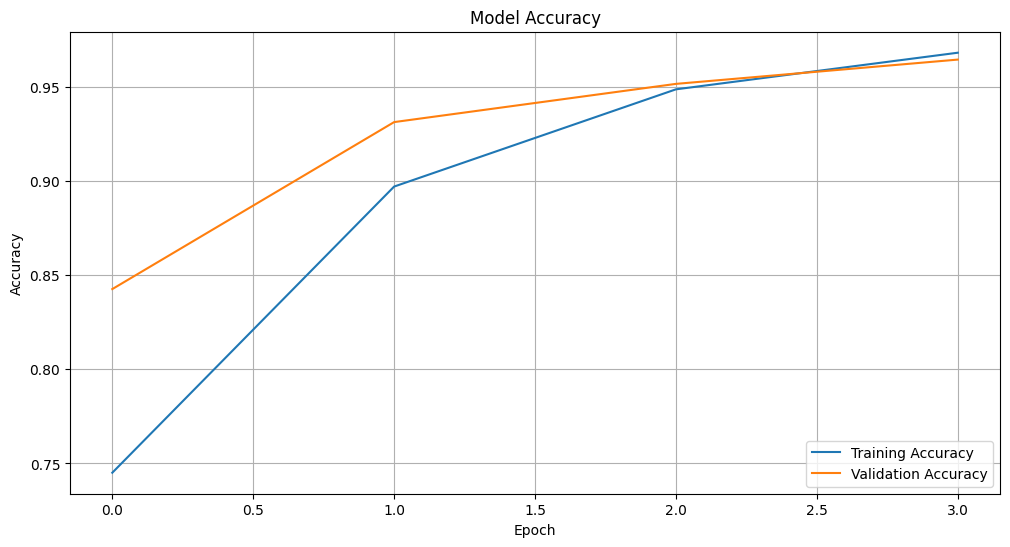

In [38]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

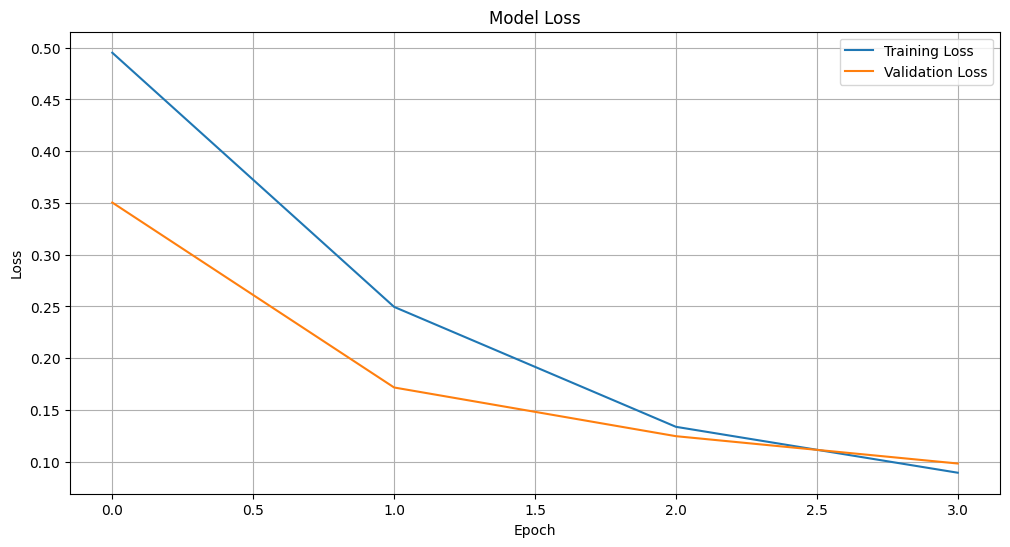

In [39]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [40]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)

# The model output is the probability of the image being real
# Convert probabilities to percentage
predicted_percentages = predictions * 100

# Convert to predicted classes with a threshold of 50%
predicted_classes = np.where(predicted_percentages > 50, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

438/438 [==============================] - 117s 268ms/step
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96      7000
        real       0.97      0.95      0.96      7000

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000



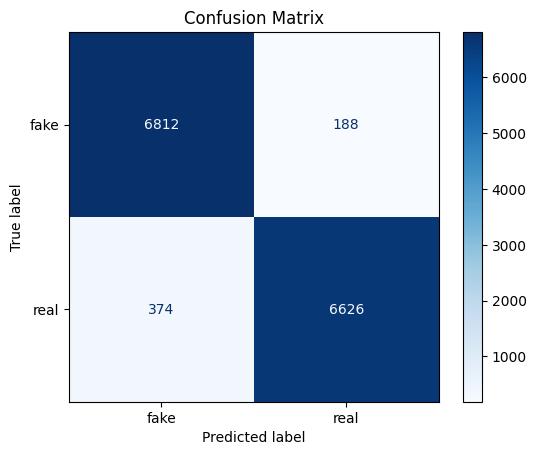

In [41]:
# 3. Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 182ms/step


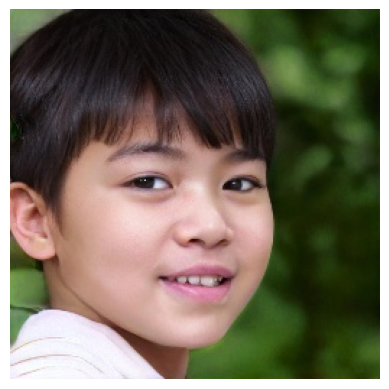

The model predicts this image is 'real' with a confidence of 0.04%.
The model predicts this image is 'fake' with a confidence of 99.96%.


In [42]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load image
    img = image.load_img(img_path, target_size=target_size)

    # Convert image to array
    img_array = image.img_to_array(img)

    # Rescale the image
    img_array = img_array / 255.0

    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

img_path = '140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake/00W5NPIX4S.jpg'
target_size = (256, 256)  # Make sure this matches your model's input size

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path, target_size)

# Make a prediction
prediction = model.predict(img_array)

# Get the percentage for both classes
real_confidence = prediction[0][0] * 100
fake_confidence = (1 - prediction[0][0]) * 100

plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Print the results
print(f"The model predicts this image is 'real' with a confidence of {real_confidence:.2f}%.")
print(f"The model predicts this image is 'fake' with a confidence of {fake_confidence:.2f}%.")